In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import time

### `generate_dataset`

#### Parameters:
- `n_samples`: Number of data points.
- `n_true_predictors`: Number of effective features.
- `n_non_effective_predictors`: Number of noise features.

#### Steps:

1. **Generate Predictors**:  
   **True Predictors**: `n_true_predictors` arrays of random values.  
   **Non-effective Predictors**: `n_non_effective_predictors` arrays of random values.

2. **Define Coefficients and Intercept**:  
   `beta_0`: Intercept (3.0).  
   `true_coefficients`: Random values (3.5 to 8) for true predictors.

3. **Generate Error Term**:  
   Random noise from a standard normal distribution.

4. **Generate Outcome Variable (`y`)**:  
   Calculated as the sum of the intercept, true predictors multiplied by their coefficients, and the error term.

5. **Combine Predictors into a DataFrame**:  
   Creates a DataFrame with predictors and the outcome variable `y`.

6. **Return**:  
   The DataFrame and true coefficients.

In [29]:
def generate_dataset(n_samples, n_true_predictors, n_non_effective_predictors):
    np.random.seed(8)
    
    # Generate true predictors
    true_predictors = [np.random.rand(n_samples, 1) for _ in range(n_true_predictors)]
    
    # Generate non-effective predictors
    non_effective_predictors = [np.random.rand(n_samples, 1) for _ in range(n_non_effective_predictors)]
    
    # Define the true coefficients and intercept
    beta_0 = 3.0
    true_coefficients = np.random.uniform(2, 10, size=n_true_predictors)
    
    # Generate the error term
    error = np.random.randn(n_samples, 1)
    
    # Generate the outcome variable
    y = beta_0 + sum(beta * x for beta, x in zip(true_coefficients, true_predictors)) + error
    
    # Combine all predictors into a single DataFrame
    predictors = np.hstack(true_predictors + non_effective_predictors)
    columns = [f'x{i+1}' for i in range(n_true_predictors + n_non_effective_predictors)]
    data = pd.DataFrame(predictors, columns=columns)
    data['y'] = y
    
    return data, true_coefficients

In [30]:
# Generate the dataset
n_samples = 20_000
n_true_predictors = 20
n_non_effective_predictors = 100
data, true_coefficients = generate_dataset(n_samples, n_true_predictors, n_non_effective_predictors)

true_coefficients

array([9.1386484 , 2.46176157, 9.9170475 , 9.72920768, 4.60721102,
       7.44648299, 3.75048408, 6.91211441, 5.02960563, 5.26979551,
       3.43037269, 9.30399961, 2.66388582, 7.02646302, 4.50542089,
       3.81571246, 7.91123314, 3.14057372, 7.02473947, 7.32357454])

In [31]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x112,x113,x114,x115,x116,x117,x118,x119,x120,y
0,0.873429,0.475082,0.372132,0.849903,0.254798,0.622415,0.281683,0.029728,0.905507,0.918060,...,0.073502,0.393554,0.758565,0.051763,0.707732,0.014156,0.059247,0.829307,0.835094,69.537350
1,0.968541,0.771450,0.077522,0.843904,0.066323,0.703808,0.698935,0.326733,0.702265,0.122268,...,0.594942,0.124756,0.243259,0.073634,0.738715,0.844771,0.244747,0.623719,0.681425,75.633004
2,0.869195,0.812549,0.189379,0.565280,0.325774,0.999498,0.221246,0.824254,0.027894,0.045276,...,0.864974,0.933768,0.595107,0.703457,0.517843,0.146553,0.360619,0.639205,0.983256,55.070976
3,0.530856,0.393791,0.946634,0.559811,0.868602,0.646753,0.097998,0.830758,0.789780,0.469445,...,0.131763,0.022288,0.485410,0.616666,0.810693,0.904833,0.807056,0.225279,0.785639,70.581896
4,0.232728,0.073132,0.114611,0.961259,0.828392,0.062560,0.065954,0.428678,0.228203,0.301499,...,0.716743,0.751749,0.025244,0.093847,0.276883,0.347541,0.036358,0.325093,0.263344,53.538262


In [32]:
data.shape

(20000, 121)

In [33]:
X = data.drop(columns='y')
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Basic linear model for baseline coeff in order to compare how Lasso changes the coeff

In [34]:
basic_lr = LinearRegression()

# Fit the model to the training data
basic_lr.fit(X_train, y_train)

lr_pred = basic_lr.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, lr_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.0381523133219985


In [35]:
initial_coefficients = basic_lr.coef_
initial_coefficients

array([ 9.14198155e+00,  2.42385660e+00,  9.87767832e+00,  9.70002199e+00,
        4.61580848e+00,  7.45134285e+00,  3.76278158e+00,  6.87701235e+00,
        5.05113635e+00,  5.26521549e+00,  3.47460575e+00,  9.25709355e+00,
        2.70564826e+00,  7.04546923e+00,  4.52110387e+00,  3.81651613e+00,
        7.96812659e+00,  3.15047209e+00,  7.00113804e+00,  7.33377878e+00,
        3.04332502e-03,  8.34089499e-03,  1.94453535e-02,  1.41128693e-02,
       -1.99512926e-02,  5.47192963e-02, -1.28331735e-02,  4.66613994e-02,
       -5.01578536e-03, -2.58480978e-02,  3.96038351e-02,  8.80954053e-03,
        1.44839931e-02,  4.43306661e-03, -3.39634132e-02, -4.40829315e-03,
       -2.37585376e-02,  1.87950419e-02,  2.19652695e-03,  2.14626543e-02,
        7.17907509e-03,  2.60779625e-02,  4.09351373e-02,  2.46959839e-02,
       -2.31212734e-02,  1.21483398e-03,  2.47546902e-02,  1.14024100e-04,
       -6.05399819e-02,  1.79185211e-03,  2.08434066e-03, -5.70477061e-02,
       -3.41509988e-02,  

In [36]:
# Define the Lasso model
lasso = LassoCV(cv=5, random_state=8, n_jobs=-1)  

start_time = time.time()
lasso.fit(X_train, y_train)

best_alpha = lasso.alpha_
print("Optimal alpha:", best_alpha)

Optimal alpha: 0.0024101175795576257


In [37]:
lasso_final = Lasso(alpha=best_alpha)

# Fit the final model to the training data
lasso_final.fit(X_train, y_train)

# Predict on test data and time
y_pred = lasso_final.predict(X_test)
end_time = time.time()

In [38]:
# Calculate the mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 1.016204214192427


In [39]:
r2 = r2_score(y_test, y_pred)
print(f"R^2 score: {r2}")

R^2 score: 0.9854069432144702


In [40]:
estimation_time = end_time - start_time
print(estimation_time)

0.4273688793182373


In [41]:
lasso_coefficients = lasso_final.coef_
lasso_coefficients

array([ 9.11235674e+00,  2.39585463e+00,  9.85016081e+00,  9.66911018e+00,
        4.58727728e+00,  7.42346009e+00,  3.73392389e+00,  6.84521709e+00,
        5.01910018e+00,  5.23480918e+00,  3.44753117e+00,  9.22783578e+00,
        2.67709968e+00,  7.01643011e+00,  4.49390755e+00,  3.78725011e+00,
        7.93786327e+00,  3.12074415e+00,  6.97184763e+00,  7.30151730e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  2.83953295e-02, -0.00000000e+00,  1.90542865e-02,
       -0.00000000e+00, -0.00000000e+00,  1.22370187e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.09590449e-03, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.15229411e-02,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.03370307e-02,  0.00000000e+00,  0.00000000e+00, -2.47611938e-02,
       -4.13370878e-03,  

In [42]:
start_time = time.time()

# Create a DataFrame to compare the coefficients
coefficients_df = pd.DataFrame({
    'Feature_Index': np.arange(len(X.columns)),
    'Feature': X.columns,
    'Initial_Coefficients': initial_coefficients,
    'Lasso_Coefficients': lasso_coefficients
})

zero_indices = coefficients_df[coefficients_df['Lasso_Coefficients'] == 0]['Feature_Index']

In [43]:
coefficients_df

,Feature_Index,Feature,Initial_Coefficients,Lasso_Coefficients
0,0,x1,9.141982,9.112357
1,1,x2,2.423857,2.395855
2,2,x3,9.877678,9.850161
3,3,x4,9.700022,9.669110
4,4,x5,4.615808,4.587277
...,...,...,...,...
115,115,x116,-0.027314,-0.000000
116,116,x117,0.006210,0.000000
117,117,x118,-0.010819,-0.000000
118,118,x119,0.005303,0.000000


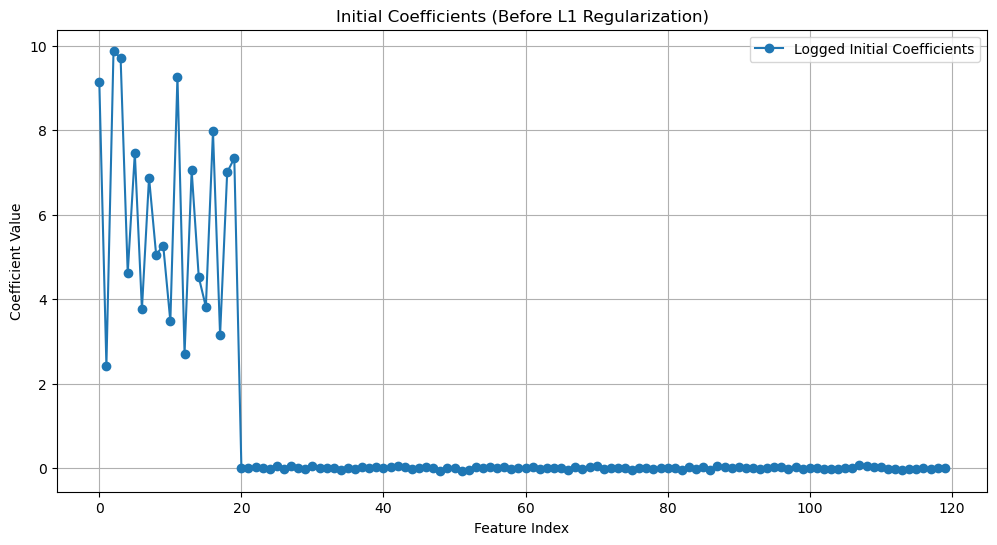

In [44]:
# Plot initial coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Initial_Coefficients'], marker='o', label='Logged Initial Coefficients', linestyle='-')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Initial Coefficients (Before L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()


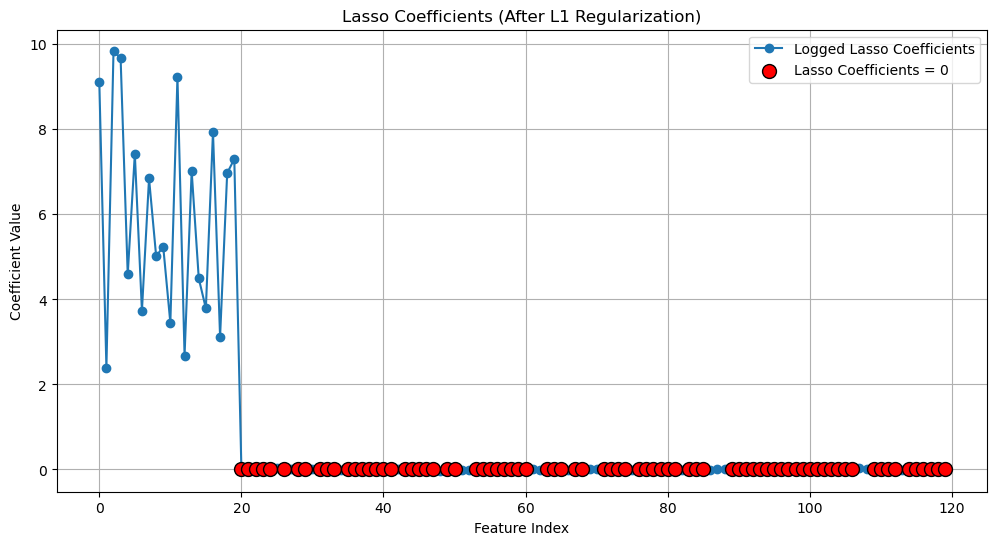

In [45]:
# Plot Lasso coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Lasso_Coefficients'], marker='o', label='Logged Lasso Coefficients', linestyle='-')
plt.scatter(zero_indices, np.zeros(len(zero_indices)), color='red', edgecolor='black', s=100, zorder=5, label='Lasso Coefficients = 0')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients (After L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
coefficients_df = coefficients_df.sort_values(by="Lasso_Coefficients", ascending=False).reset_index(drop=True)
coefficients_df

,Feature_Index,Feature,Initial_Coefficients,Lasso_Coefficients
0,2,x3,9.877678,9.850161
1,3,x4,9.700022,9.669110
2,11,x12,9.257094,9.227836
3,0,x1,9.141982,9.112357
4,16,x17,7.968127,7.937863
...,...,...,...,...
115,66,x67,-0.046426,-0.017698
116,82,x83,-0.049822,-0.019893
117,113,x114,-0.050139,-0.021396
118,51,x52,-0.057048,-0.024761


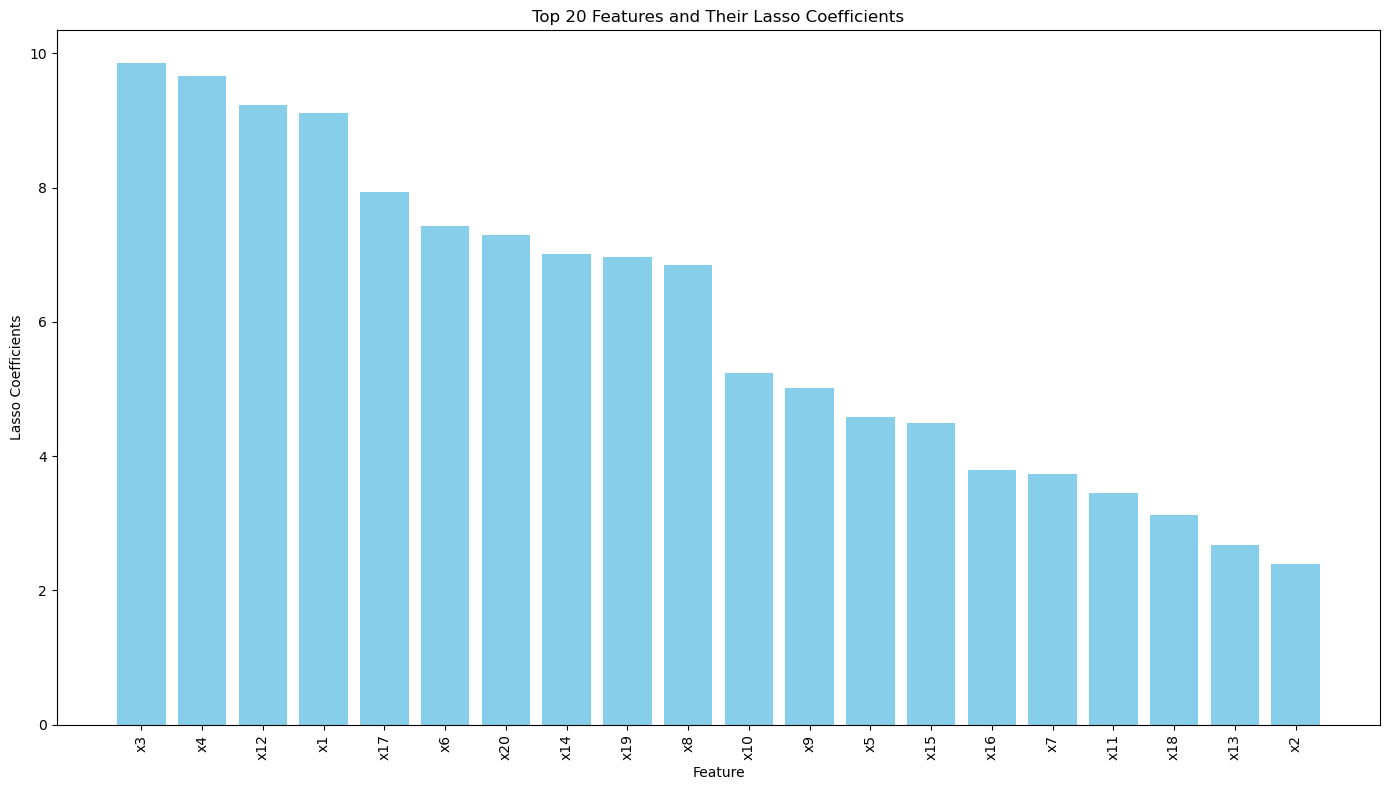

In [47]:
top_20_features = coefficients_df[['Feature', 'Lasso_Coefficients']]
top_20_filtered_df = top_20_features.head(20)

plt.figure(figsize=(14, 8))

plt.bar(top_20_filtered_df['Feature'], top_20_filtered_df['Lasso_Coefficients'], color='skyblue')

plt.xlabel('Feature')
plt.ylabel('Lasso Coefficients')
plt.title('Top 20 Features and Their Lasso Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

end_time = time.time()

In [48]:
explainability_time = end_time - start_time

In [49]:
# Create a DataFrame for the results
results = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_pred}).reset_index(drop=True)
results

,True Values,Predicted Values
0,80.256052,79.535495
1,55.685994,56.933941
2,66.021926,66.578132
3,62.128934,62.410472
4,54.489945,55.891246
...,...,...
3995,81.257315,81.446385
3996,77.487563,75.986476
3997,53.039140,53.789535
3998,70.108174,69.791522


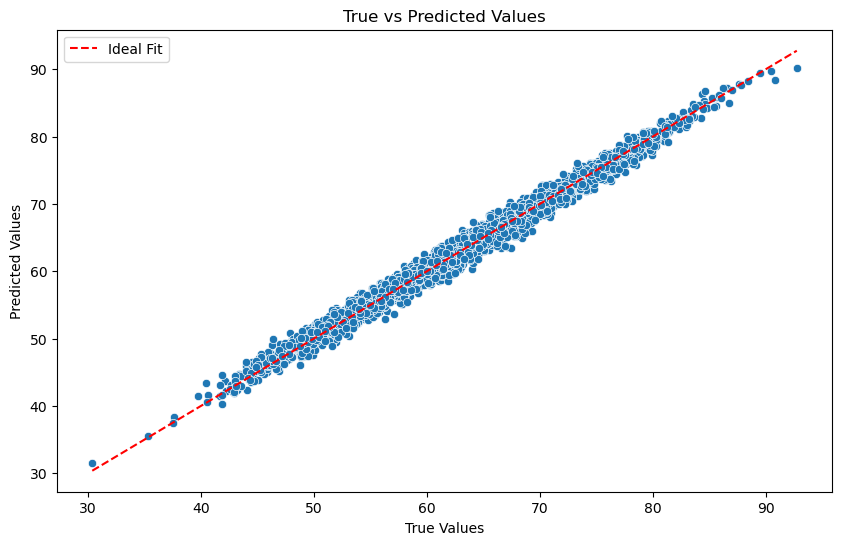

In [50]:
# Plot the true vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='True Values', y='Predicted Values', data=results)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

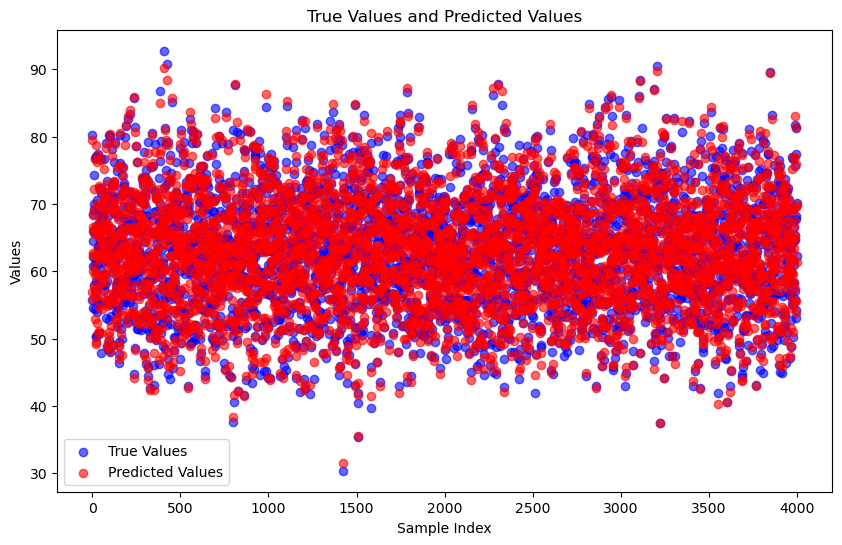

In [51]:
# Plot the true vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.6, label='True Values')
plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.6, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('True Values and Predicted Values')
plt.legend()
plt.show()

In [52]:
# # Exclude non-numeric columns
# corrmat = data.corr()

# f, ax = plt.subplots(figsize=(15, 12))
# sns.heatmap(corrmat, annot=True);

In [53]:
# # Threshold for identifying multicollinearity
# threshold = 0.5

# # Find pairs of highly correlated features
# high_corr_var = {}
# for i in range(len(corrmat.columns)):
#     for j in range(i):
#         if abs(corrmat.iloc[i, j]) > threshold:
#             colname = corrmat.columns[i]
#             if colname not in high_corr_var:
#                 high_corr_var[colname] = corrmat.columns[j]

# print("Highly correlated features (above threshold of {}):".format(threshold))
# for key, value in high_corr_var.items():
#     print(key, "<--->", value)

## shows no multicollinearity in random generated data

# Time to collect result metrics

In [54]:
lasso_metrics = []
# LassoCV model metrics
#fpr, fnr = calculate_fp_fn_rates(cf_matrix)
lasso_metrics.append({
    'Simulation Size': '20-100-20_000',
    'Model': 'Lasso',
    'Inference Time (sec)': round(estimation_time, 3),
    'R Squared': r2,
    'RMSE': rmse,
    'Explanation/Interpretation Task': 'Interpret LASSO',
    'Interpretation Time (sec)': round(explainability_time, 3),
    #'top_20_features': top_20_features_str
    # 'auc': round(roc_auc, 3),
    # 'false_positive_rate': round(fpr, 3),
    # 'false_negative_rate': round(fnr, 3)
})

lasso_metrics_df = pd.DataFrame(lasso_metrics)
lasso_metrics_df

,Simulation Size,Model,Inference Time (sec),R Squared,RMSE,Explanation/Interpretation Task,Interpretation Time (sec)
0,20-100-20_000,Lasso,0.427,0.985407,1.016204,Interpret LASSO,1.011


In [55]:
lasso_metrics_df.to_csv('20-100-20_000-metrics.csv', index=False)